In [1]:
import contextlib
from functools import lru_cache

import boto3
import cf_xarray  # noqa: F401
import duckdb
import icechunk
import numpy as np
import numpy.typing as npt
import xarray as xr
from dask.utils import format_bytes

from ocr.config import OCRConfig
from ocr.utils import apply_s3_creds, install_load_extensions

In [2]:
@lru_cache(maxsize=128)
def get_s3_directory_size_resource(bucket_name, prefix):
    """
    Calculate directory size using boto3 resource interface.
    """
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)

    total_size = 0
    for obj in bucket.objects.filter(Prefix=prefix):
        total_size += obj.size

    return total_size

In [3]:
default_fillvals = {
    'S1': '\x00',
    'i1': -127,
    'u1': 255,
    'i2': -32767,
    'u2': 65535,
    'i4': -2147483647,
    'u4': 4294967295,
    'i8': -9223372036854775806,
    'u8': 18446744073709551614,
    'f4': 9.969209968386869e36,
    'f8': 9.969209968386869e36,
}


def set_zarr_encoding(
    ds: xr.Dataset,
    codec_config: dict | None = None,
    float_dtype: npt.DTypeLike | None = None,
    int_dtype: npt.DTypeLike | None = None,
    datetime_dtype: npt.DTypeLike | None = None,
    object_dtype: npt.DTypeLike | None = None,
) -> xr.Dataset:
    """Set zarr encoding for each variable in the dataset

    Parameters
    ----------
    ds : xr.Dataset
        Input dataset
    codec_config : dict, optional
        Dictionary of parameters to pass to numcodecs.get_codec.
        The default is {'id': 'zlib', 'level': 1}
    float_dtype : str or dtype, optional
        Dtype to cast floating point variables to
    int_dtype : str or dtype, optional
        Dtype to cast integer variables to
    object_dtype : str or dtype, optional
        Dtype to cast object variables to.
    datetime_dtype : str or dtype, optional
        Dtype to encode numpy.datetime64 variables as.
        Time coordinates are encoded as 'int32' if cf_xarray
        is able to identify the coordinates representing time,
        even if `datetime_dtype` is None.


    Returns
    -------
    ds : xr.Dataset
        Output dataset with updated variable encodings

    Notes
    -----
    The *_dtype parameters can be used to coerce variables into data types
    readable by Zarr implementations in other languages.

    """
    import numcodecs

    ds = ds.copy()

    if codec_config is None:
        codec_config = {'id': 'zlib', 'level': 1}
    compressor = numcodecs.get_codec(codec_config)

    time_vars = ds.cf.axes.get('T', []) + ds.cf.bounds.get('T', [])
    for varname, da in ds.variables.items():
        # remove old encoding
        da.encoding.clear()

        # maybe cast data type
        if np.issubdtype(da.dtype, np.floating) and float_dtype is not None:
            da = da.astype(float_dtype)
            da.encoding['dtype'] = str(float_dtype)
        elif np.issubdtype(da.dtype, np.integer) and int_dtype is not None:
            da = da.astype(int_dtype)
            da.encoding['dtype'] = str(int_dtype)
        elif da.dtype == 'O' and object_dtype is not None:
            da = da.astype(object_dtype)
            da.encoding['dtype'] = str(object_dtype)
        elif np.issubdtype(da.dtype, np.datetime64) and datetime_dtype is not None:
            da.encoding['dtype'] = str(datetime_dtype)
        elif varname in time_vars:
            da.encoding['dtype'] = 'int32'

        # update with new encoding
        da.encoding['compressor'] = compressor
        with contextlib.suppress(KeyError):
            del da.attrs['_FillValue']
        da.encoding['_FillValue'] = default_fillvals.get(da.dtype.str[-2:], None)

        ds[varname] = da

    return ds

In [4]:
version = '1.0.0'

In [5]:
config = OCRConfig(environment='production', storage_root='s3://carbonplan-ocr', version=version)

In [6]:
storage = icechunk.s3_storage(bucket='carbonplan-ocr', prefix=config.icechunk.prefix)
repo = icechunk.Repository.open(storage)
session = repo.readonly_session('main')

ds = xr.open_dataset(session.store, chunks={}, engine='zarr')
ds

<xarray.Dataset> Size: 652GB
Dimensions:        (latitude: 97579, longitude: 208881)
Coordinates:
  * latitude       (latitude) float64 781kB 22.43 22.43 22.43 ... 52.48 52.48
  * longitude      (longitude) float64 2MB -128.4 -128.4 ... -64.05 -64.05
Data variables:
    bp_2011        (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    bp_2011_riley  (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    bp_2047        (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    crps_scott     (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    rps_2011       (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    rps_2047       (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    rps_scott      (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    bp_2047_riley  (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
Attributes:
    version:          1.0.0
    provider:         CarbonPlan
    terms_of_access:  https://docs.carbonplan.org/ocr/en/latest/terms-of-data...
    data_sources:     https://docs.carbonplan.org/ocr/en/latest/reference/dat...
    license_name:     CC-BY-4.0
    license_url:      https://creativecommons.org/licenses/by/4.0/

In [7]:
%%time
icechunk_size = get_s3_directory_size_resource('carbonplan-ocr', prefix=config.icechunk.prefix)
format_bytes(icechunk_size)

CPU times: user 19.5 s, sys: 98.5 ms, total: 19.6 s
Wall time: 48.1 s


'237.70 GiB'

## Figure 1

minimaps-compatible Zarr store
- two variables: wind_risk_2011 and wind_risk_2047
- CONUS extent
- coarsened to ~200x400 array size (rough estimate based on seaweed farming example)

In [8]:
store1 = (
    ds[['rps_2011', 'rps_2047']]
    .coarsen({'longitude': 500, 'latitude': 400}, boundary='trim')
    .mean()
    .chunk({'latitude': -1, 'longitude': -1})
    .pipe(set_zarr_encoding)
)
store1

<xarray.Dataset> Size: 816kB
Dimensions:    (latitude: 243, longitude: 417)
Coordinates:
  * latitude   (latitude) float64 2kB 22.49 22.61 22.74 ... 52.06 52.18 52.3
  * longitude  (longitude) float64 3kB -128.3 -128.2 -128.0 ... -64.4 -64.25
Data variables:
    rps_2011   (latitude, longitude) float32 405kB dask.array<chunksize=(243, 417), meta=np.ndarray>
    rps_2047   (latitude, longitude) float32 405kB dask.array<chunksize=(243, 417), meta=np.ndarray>
Attributes:
    version:          1.0.0
    provider:         CarbonPlan
    terms_of_access:  https://docs.carbonplan.org/ocr/en/latest/terms-of-data...
    data_sources:     https://docs.carbonplan.org/ocr/en/latest/reference/dat...
    license_name:     CC-BY-4.0
    license_url:      https://creativecommons.org/licenses/by/4.0/

In [9]:
path1 = f's3://carbonplan-ocr/output/fire-risk/tensor/web-figures/v{version}/store1.zarr'
path1

's3://carbonplan-ocr/output/fire-risk/tensor/web-figures/v1.0.0/store1.zarr'

In [10]:
%%time
store1.to_zarr(
    path1,
    zarr_format=2,
    consolidated=True,
)

CPU times: user 3min 3s, sys: 1min 33s, total: 4min 37s
Wall time: 1min 1s


## Figure 3

minimaps-compatible Zarr store
- two variables: wind_risk_2011 and USFS_RPS
- regional extent (see figure above)
- similar array size to Figure 1

(lower priority) geojson
- buildings over regional extent w/ wind_risk_2011 and USFS_RPS scores

In [11]:
store3 = (
    ds[['rps_2011', 'rps_scott']]
    .sel(latitude=slice(34.14, 34.23), longitude=slice(-118.18, -118.06))
    .chunk({'latitude': -1, 'longitude': -1})
    .pipe(set_zarr_encoding)
)
store3

<xarray.Dataset> Size: 920kB
Dimensions:    (latitude: 293, longitude: 390)
Coordinates:
  * latitude   (latitude) float64 2kB 34.14 34.14 34.14 ... 34.23 34.23 34.23
  * longitude  (longitude) float64 3kB -118.2 -118.2 -118.2 ... -118.1 -118.1
Data variables:
    rps_2011   (latitude, longitude) float32 457kB dask.array<chunksize=(293, 390), meta=np.ndarray>
    rps_scott  (latitude, longitude) float32 457kB dask.array<chunksize=(293, 390), meta=np.ndarray>
Attributes:
    version:          1.0.0
    provider:         CarbonPlan
    terms_of_access:  https://docs.carbonplan.org/ocr/en/latest/terms-of-data...
    data_sources:     https://docs.carbonplan.org/ocr/en/latest/reference/dat...
    license_name:     CC-BY-4.0
    license_url:      https://creativecommons.org/licenses/by/4.0/

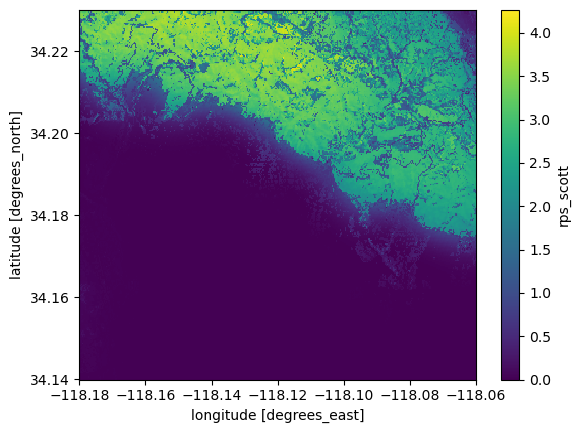

In [12]:
store3.rps_scott.plot()

In [13]:
path3 = f's3://carbonplan-ocr/output/fire-risk/tensor/web-figures/v{version}/store3.zarr'
path3

's3://carbonplan-ocr/output/fire-risk/tensor/web-figures/v1.0.0/store3.zarr'

In [15]:
%%time
store3.to_zarr(
    path3,
    zarr_format=2,
    consolidated=True,
)

CPU times: user 473 ms, sys: 281 ms, total: 753 ms
Wall time: 1.41 s


## Table 1

summary statistics

- # of buildings in geoparquet dataset
- if possible, # bytes of dataset
  - sort of subjective what we call this — could just be size of geoparquet + icechunk stores?

In [7]:
connection = duckdb.connect()
apply_s3_creds(con=connection)
install_load_extensions(con=connection)

In [8]:
input_path = f'{config.vector.building_geoparquet_uri}/**/data_*.parquet'
input_path

's3://carbonplan-ocr/output/fire-risk/vector/production/v1.0.0/geoparquet/buildings.parquet/**/data_*.parquet'

In [18]:
# Count total number of buildings
building_count = connection.execute(f"""
SELECT COUNT(*) as total_buildings
FROM '{input_path}'
""").fetchone()[0]

print(f'Total number of buildings: {building_count:,}')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total number of buildings: 155,572,451


In [19]:
prefix = f'{config.vector.building_geoparquet_uri}'.split('carbonplan-ocr')[-1].strip('/')
prefix

'output/fire-risk/vector/production/v1.0.0/geoparquet/buildings.parquet'

In [20]:
%%time
# Get total size of geoparquet dataset in bytes
geoparquet_size = get_s3_directory_size_resource('carbonplan-ocr', prefix=prefix)
format_bytes(geoparquet_size)

CPU times: user 556 ms, sys: 2.92 ms, total: 559 ms
Wall time: 1.42 s


'17.67 GiB'

In [9]:
output_path = (
    f's3://carbonplan-ocr/output/fire-risk/vector/web-figures/v{version}/figure3-buildings.geojson'
)
output_path

's3://carbonplan-ocr/output/fire-risk/vector/web-figures/v1.0.0/figure3-buildings.geojson'

In [10]:
query = f"""
    COPY (
        SELECT rps_2011, rps_scott, geometry
        FROM read_parquet('{input_path}')
        WHERE bbox.xmin <= -118.06
          AND bbox.xmax >= -118.18
          AND bbox.ymin <= 34.23
          AND bbox.ymax >= 34.14
    ) TO '{output_path}'
    WITH (FORMAT GDAL, DRIVER 'GeoJSON')
"""

connection.execute(query)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))